In [92]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics
import math
from scipy import stats

## Define which experiments results we want to examine

In [884]:
RESULTS_FOLDER = "../results/Covtype_1_MSE/"

In [1189]:
FILENAME = "covtype--triangle-1000-1-40-random"

## Parse the custom output format into a dataframe

In [1190]:
def parseNonHeuristic(line, columns):
    # drop the brackets and "non-heuristic," at the start
    line = line[15:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseHeuristic(line, columns):
    # drop the brackets
    line = line[11:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseRunResult(result, nonHeuristicDf, heuristicDf):
    line = line[1:-1]
    runner = result[0].split(":")[0]
    parseNonHeuristic(result[1])
    print("Runner", runner)
    
    return

def readResultsFile(filename):
    nonHeuristicDf = pd.DataFrame(columns=['runtime-non','mse-non','iterations-non'])
    heuristicDf = pd.DataFrame(columns=['runtime-heur','mse-achieved','mse-heur','iterations-heur','pim','stagnation'])

    with open(RESULTS_FOLDER + filename, 'r') as filehandle:
        currentRunner = None
        for line in filehandle:
            line = line[:-1]
            if ":" in line:
                currentRunner = line.split(":")[0]
            elif line.startswith("non-heuristic"):
                parsedLine = parseNonHeuristic(line, list(nonHeuristicDf.columns)),  
                nonHeuristicDf = nonHeuristicDf.append(parsedLine,ignore_index = True)
            elif line.startswith("heuristic"):
                parsedLine = parseHeuristic(line, list(heuristicDf.columns)),  
                heuristicDf = heuristicDf.append(parsedLine, ignore_index = True)
            else:
                raise Exception("Unknown line:", line)
    heuristicDf['runtime-heur'] =  heuristicDf['runtime-heur'].astype(float, errors = 'raise')
    heuristicDf['iterations-heur'] = heuristicDf['iterations-heur'].astype(int)
    heuristicDf['mse-achieved'] = heuristicDf['mse-achieved'].map(lambda x: x=="True")
    heuristicDf['mse-achieved'] =  heuristicDf['mse-achieved'].astype('bool')
    heuristicDf['stagnation'] = heuristicDf['stagnation'].map(lambda x: x=="True")
    heuristicDf['stagnation'] =  heuristicDf['stagnation'].astype(bool)
    nonHeuristicDf['runtime-non'] =  nonHeuristicDf['runtime-non'].astype(float, errors = 'raise')
    nonHeuristicDf['iterations-non'] = nonHeuristicDf['iterations-non'].astype(int)

    return nonHeuristicDf, heuristicDf

nonHeuristicDf, heuristicDf = readResultsFile(FILENAME)

In [1191]:
results = nonHeuristicDf.merge(heuristicDf, left_index=True, right_index=True)
results

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
0,1179.202,4223320695.8581324,7,979.878,True,4200577726.2894354,9,0,False
1,1182.956,4212861655.946151,7,946.185,True,4179669952.6400013,9,0,False
2,1141.743,4199281445.066827,7,972.589,True,4175117544.729352,10,0,False
3,1147.067,4203873801.742853,7,970.323,True,4172170387.647952,10,0,False
4,1176.158,4261435450.7216396,7,824.111,True,4203548760.3076577,7,0,False
5,1188.541,4212312926.7739615,7,951.113,True,4185073105.7516675,9,0,False
6,1182.836,4240813436.0044847,7,904.153,True,4194990675.129625,8,0,False
7,1206.185,4245378138.1183205,7,882.900,True,4218143928.764841,8,0,False
8,1152.430,4216949684.9174685,7,948.221,True,4179588577.755398,9,0,False
9,1201.214,4258739796.479126,7,844.113,True,4208703076.6070204,7,0,False


# Calculate average speedup

As stated in the report only take a look at the replicates that did not result in stagnation

In [1192]:
speedupRelevant = results[results.stagnation == False]
speedupRelevant

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
0,1179.202,4223320695.8581324,7,979.878,True,4200577726.2894354,9,0,False
1,1182.956,4212861655.946151,7,946.185,True,4179669952.6400013,9,0,False
2,1141.743,4199281445.066827,7,972.589,True,4175117544.729352,10,0,False
3,1147.067,4203873801.742853,7,970.323,True,4172170387.647952,10,0,False
4,1176.158,4261435450.7216396,7,824.111,True,4203548760.3076577,7,0,False
5,1188.541,4212312926.7739615,7,951.113,True,4185073105.7516675,9,0,False
6,1182.836,4240813436.0044847,7,904.153,True,4194990675.129625,8,0,False
7,1206.185,4245378138.1183205,7,882.900,True,4218143928.764841,8,0,False
8,1152.430,4216949684.9174685,7,948.221,True,4179588577.755398,9,0,False
9,1201.214,4258739796.479126,7,844.113,True,4208703076.6070204,7,0,False


Calculate the average speedup across all non-stagnated replicates ('Measured speedup' value reported in the report)

In [1193]:
# speedup of the heuristic method
measuredSpeedup = speedupRelevant['runtime-non'].sum()/speedupRelevant['runtime-heur'].sum()
measuredSpeedup

1.2748113369092016

Calculate the standard deviation of speedup (note that this will not be possible if we don't have at least 2 replicates that didn't stagnate)

In [1194]:
if(len(speedupRelevant) < 2):
    raise Exception("Should not continue only a single non-stagnated replicate was found")

In [1195]:
speedups = speedupRelevant['runtime-non'] / speedupRelevant['runtime-heur']
statistics.stdev(speedups)

0.09604707362298062

Calculate the proportion of replicates that stagnated

In [1196]:
# proportion stagnated
len(results[results.stagnation == True])/len(results)

0.0

Take a look at the distribution of speedups of non-stagnated replicates - the base for significance testing

(array([2., 2., 1., 1., 0., 1., 0., 1., 0., 2.]),
 array([1.17392136, 1.19924762, 1.22457388, 1.24990014, 1.2752264 ,
        1.30055266, 1.32587892, 1.35120518, 1.37653144, 1.4018577 ,
        1.42718396]),
 <a list of 10 Patch objects>)

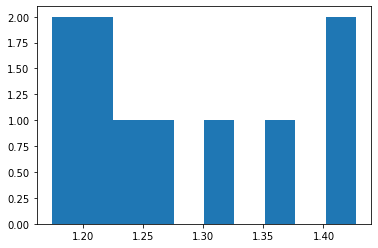

In [1197]:
plt.hist(speedups)

## Significance tests

Use speedup for each replicate, only include the replicates that did not stagnate

In [1198]:
speedups

0    1.203417
1    1.250238
2    1.173921
3    1.182150
4    1.427184
5    1.249632
6    1.308225
7    1.366163
8    1.215360
9    1.423049
dtype: float64

We can use the ditribution of of our replicates to find the probability of getting reported result value

In [1199]:
# Take the value they reported and substitute it here
REPORTED_SPEEDUP_VALUE = 3.05
# significance level
alpha = 0.05
# seed for reproducibility
seed = 12345

### Approach 1: Using CLT to get normal distribution

As the data might not be normal we sample and do mean, note that higher replicate counts should be used to run the experiment so that we have more values to sample from.

(array([  4.,  44., 116., 221., 266., 176., 122.,  42.,   8.,   1.]),
 array([1.24045287, 1.2492676 , 1.25808234, 1.26689707, 1.27571181,
        1.28452654, 1.29334127, 1.30215601, 1.31097074, 1.31978548,
        1.32860021]),
 <a list of 10 Patch objects>)

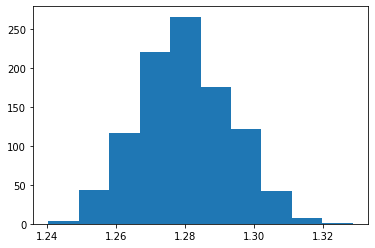

In [1200]:
import numpy as np

# sample 50 items 1000 times
n = 50
sampleTimes = 1000

sampleNumber = 0
means = []
while sampleNumber < sampleTimes: 
    sampleMean = np.mean(np.random.choice(speedups,n))
    means.append(sampleMean)
    sampleNumber += 1

plt.hist(means)

Calculate the critical value for our significance level to compare the t-statistic to:

In [1201]:
criticalValue = stats.t.ppf(1-alpha, n-1)
criticalValue

1.6765508919142629

Calculate the test statistic for the difference of our overall mean and the reported mean

In [1202]:
overallMeasuredMean = np.mean(means)
testStatistic = (overallMeasuredMean - REPORTED_SPEEDUP_VALUE)/(std/math.sqrt(1000))
abs(testStatistic)

2285.376603365268

And now calculate the p-value of the testStatistic

In [1203]:
pValue = stats.t.sf(abs(testStatistic), df=n-1)
# store the significance result for later
cltApproachSignificant = pValue < alpha
pValue

3.7529382243664606e-125

### Approach 2: Assuming t-test assumptions are met

Alternatively using the samples we have only, assuming t-test assumptions are met

In [1204]:
std = statistics.stdev(speedups)
std

0.09604707362298062

In [1205]:
N = len(speedups)

testStatistic = (measuredSpeedup - REPORTED_SPEEDUP_VALUE)/(std/math.sqrt(N))
print("t-Test statistic:", abs(testStatistic))

t-Test statistic: 58.44675157841624


In [1206]:
criticalValue = stats.t.ppf(1-alpha, N)
print("Critical value for current statistic and alpha=0.05: ", criticalValue)
# calculate our p-value
pValue = stats.t.sf(abs(testStatistic), df=N-1)
print("P-value of their result coming from our distribution:", pValue)
# store significance level for later
assumingSignificant =  pValue < alpha
print("Significant difference - reject H0?:", assumingSignificant)

Critical value for current statistic and alpha=0.05:  1.8124611228107335
P-value of their result coming from our distribution: 3.1646277820030023e-13
Significant difference - reject H0?: True


## Verdict

In [1207]:
print("Approach 1 significant:", cltApproachSignificant)
print("Approach 2 significant:", assumingSignificant)

Approach 1 significant: True
Approach 2 significant: True
